In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"
codes_path = '../../codes/'
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
import tqdm
import re
%matplotlib inline

In [2]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

PRS_imputed_Grove = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_nodups_euro_batch2_imputed.gwas.all_score',column_prefix='ASD_imputed_PRS_')

european_volumetric_dataset_term = european_volumetric_dataset_term.merge(PRS_imputed_Grove,on='ID')

In [3]:
available_dwi = pd.read_csv('../../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

def concat_files(files):
    to_return = pd.DataFrame()
    for variable,file in files.items():
        temp = pd.read_csv(file,delim_whitespace=True,header=None)
        temp.columns = ['ID/Ses']+[f'wm_{i}_{variable}' for i in range(94,148)]
        temp = temp.drop_duplicates('ID/Ses')
        temp['ID/Ses'] = temp['ID/Ses'].apply(lambda x: x.replace('_','/'))
        temp = temp.set_index('ID/Ses')
        to_return = pd.concat([to_return,temp],axis=1)
    return to_return.reset_index()

tract_metrics = concat_files({'fd':'../../codes/FBA/output_ASD/aba/mean_fd_not_smoothed_linear.txt',
                     'log_fc':'../../codes/FBA/output_ASD/aba/mean_log_fc_not_smoothed_linear.txt',
                     'fdc':'../../codes/FBA/output_ASD/aba/mean_fdc_not_smoothed_linear.txt'})

df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

print(df.shape)

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

print(df.shape)

df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')
print(df.shape)

df = pd.merge(df,tract_metrics,on=['ID/Ses'],how='inner')

print(df.shape)

(279, 201)
(273, 201)
(273, 202)
(221, 364)


In [4]:
df.to_csv('df_euro_fba.csv',index=False)

In [5]:
df = pd.read_csv('df_euro_fba.csv')

In [4]:
log_fc_res = pd.read_csv('tract_based_mean_log_fc_not_smoothed.csv')
fd_res = pd.read_csv('tract_based_mean_fd_not_smoothed.csv')
fdc_res = pd.read_csv('tract_based_mean_fdc_not_smoothed.csv')

fc- 102,103,96
fdc - 102,103, 116, 118

In [5]:
log_fc_res_best = log_fc_res[(log_fc_res['threshold'] == 'ASD_imputed_PRS_Pt_0.01') & (log_fc_res['PRS_pval']<0.05/6)].copy()
log_fc_res_best['tract'] = log_fc_res_best['Connection'].apply(lambda x: data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[x.replace('_log_fc','')]['abbr'])

In [62]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df=df,
    thresholds=[i for i in df.columns if 'ASD_imputed_PRS_Pt_0.05' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in df.columns if '_fd' in i and '_fdc' not in i]
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


In [63]:
test.sort_values(by='PRS_pval').head(5)

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
24,wm_118_fd,0.314392,1.372688e-216,-0.002305,0.468061,0.003574,0.054728,0.010792,1.181023e-04,0.000755,0.753138,-0.000314,0.826301,-0.001795,0.207443,0.000065,0.963398,0.003456,0.014332,ASD_imputed_PRS_Pt_0.05
22,wm_116_fd,0.245010,2.958647e-198,-0.007557,0.013173,0.002443,0.167418,0.014348,1.251225e-07,-0.004555,0.047560,-0.000496,0.716170,-0.000272,0.841029,-0.000811,0.548684,0.002520,0.060278,ASD_imputed_PRS_Pt_0.05
23,wm_117_fd,0.247373,2.993556e-206,-0.009416,0.000897,0.002575,0.115856,0.013684,5.296493e-08,-0.003461,0.102933,-0.000972,0.441108,-0.000881,0.481965,-0.001311,0.294882,0.002324,0.060903,ASD_imputed_PRS_Pt_0.05
5,wm_99_fd,0.548951,9.360296e-235,-0.009609,0.035405,0.003881,0.144199,0.021418,1.462525e-07,-0.001643,0.632516,0.002751,0.180017,-0.000703,0.729469,0.003410,0.094018,0.003638,0.070725,ASD_imputed_PRS_Pt_0.05
4,wm_98_fd,0.588142,2.042055e-226,-0.004505,0.398715,0.006388,0.041065,0.016713,3.728042e-04,-0.000434,0.914206,0.004690,0.052006,-0.000934,0.695577,0.002380,0.318277,0.004229,0.073483,ASD_imputed_PRS_Pt_0.05


In [53]:
data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()['wm_118']['side']

{'name': 'external capsule left',
 'side': 'left',
 'segment': None,
 'structure': 'external capsule',
 'abbr': 'EC.left'}

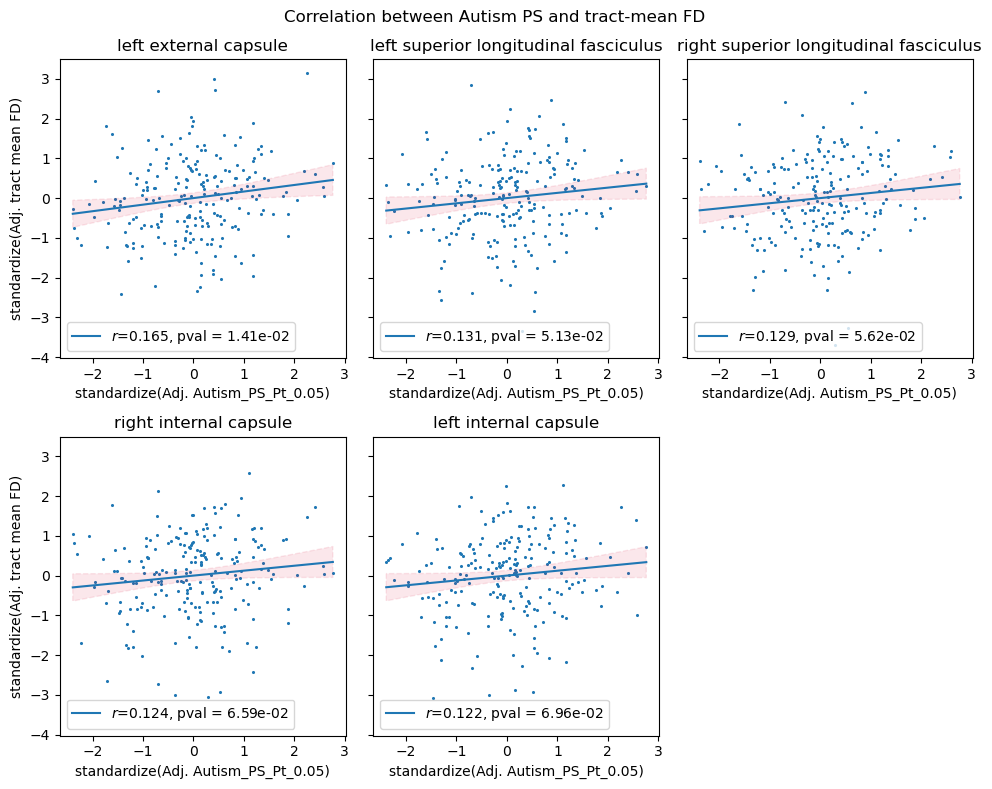

In [20]:
connections = ['wm_118','wm_116','wm_117','wm_99','wm_98']
fig,axes=plt.subplots(2,3,sharey=True,figsize=(10,8))
axes = axes.flatten()
for idx,(connection,ax) in enumerate(zip(connections,axes)):
    visualisation.SimplePlots.Scatter(
        y=connection+'_fd',
        x='ASD_imputed_PRS_Pt_0.05',
        adjust_covar={'y':['GA','PMA']+ancestry,'x':['sex']},
        data=df,
        ylabel='tract mean FD',
        ax=ax,
        xlabel='Autism_PS_Pt_0.05',
        title=data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[connection]['side'] + ' ' + data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[connection]['structure'],
        legend_loc='lower left',
    )
    if idx!=0 and idx!=3:
        ax.set_ylabel('')

fig.delaxes(axes[5])
fig.suptitle('Correlation between Autism PS and tract-mean FD')
plt.tight_layout()
# fig.savefig('../../dataset/preprocessed_dataset/fba/asd/output_plot/mean_FDC_supplementary.png')
fig.savefig('../../dataset/preprocessed_dataset/fba/asd/output_plot/mean_FD_supplementary.png')

In [14]:
r_squared_dict = defaultdict(dict)
for component in ['wm_102','wm_103']:
    for metric in ['fdc','fd','log_fc']:
        r_squared_dict[component][metric] = []
        for threshold in tqdm.tqdm([i for i in df.columns if 'ASD_imputed_PRS' in i]):
            if metric == 'fd':
                cont_independentVar_cols = [threshold,'GA','PMA']+ancestry
            else:
                cont_independentVar_cols = [threshold,'GA','PMA','TBV']+ancestry
            temp = stats.MassUnivariate.calculate_R_squared_explained(
                df,
                col_to_drop=[threshold],
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=cont_independentVar_cols,
                dependentVar_cols=[f'{component}_{metric}'])
            r_squared_dict[component][metric].append(temp)

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


In [29]:
r_squared_df = pd.DataFrame()
for name,component in zip(['SCR.L','SCR.R'],['wm_102','wm_103']):
    for metric in ['fd','log_fc','fdc']:
        temp = pd.DataFrame({'R2':r_squared_dict[component][metric]})
        temp['tract'] = name
        temp['type'] = metric
        temp['thresholds'] = [i.split('_')[-1] for i in df.columns if 'ASD_imputed_PRS' in i]
        r_squared_df = pd.concat([r_squared_df,temp])

In [30]:
prs_val_df = pd.concat([log_fc_res[['Connection','threshold','PRS_pval']],
           fdc_res[['Connection','threshold','PRS_pval']],
           fd_res[['Connection','threshold','PRS_pval']]])

prs_val_df = prs_val_df[prs_val_df['Connection'].isin([f'{i}_{metric}' for metric in ['fd','fdc','log_fc'] for i in ['wm_102','wm_103']])].copy()

prs_val_df['threshold'] = prs_val_df['threshold'].apply(lambda x: x.split('_')[-1])
prs_val_df['type'] = prs_val_df['Connection'].apply(lambda x: '_'.join(x.split('_')[-2:]) if 'log' in x else x.split('_')[-1])
prs_val_df['tract'] = prs_val_df['Connection'].apply(lambda x: 'SCR.R' if '_'.join(x.split('_')[0:2]) == 'wm_103' else 'SCR.L')
prs_val_df = prs_val_df.rename(columns={'threshold':'thresholds'})

In [31]:
r_squared_df = prs_val_df.merge(r_squared_df,on=['thresholds','type','tract']).sort_values(by='PRS_pval')
r_squared_df['significance'] = r_squared_df['PRS_pval'].apply(lambda x: '**' if x<0.05/6/54/2 else '*' if x<0.05 else '')

In [32]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_imputed_PRS_Pt_0.01','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[f'wm_{i}_log_fc' for i in range(94,148)])

to_plot_values = {int(k.replace('wm_','').replace('_log_fc','')):1-v for k,v in zip(mass_univariate.index.tolist(),mass_univariate["standardize(Q('ASD_imputed_PRS_Pt_0.01'))_pval"].values)}

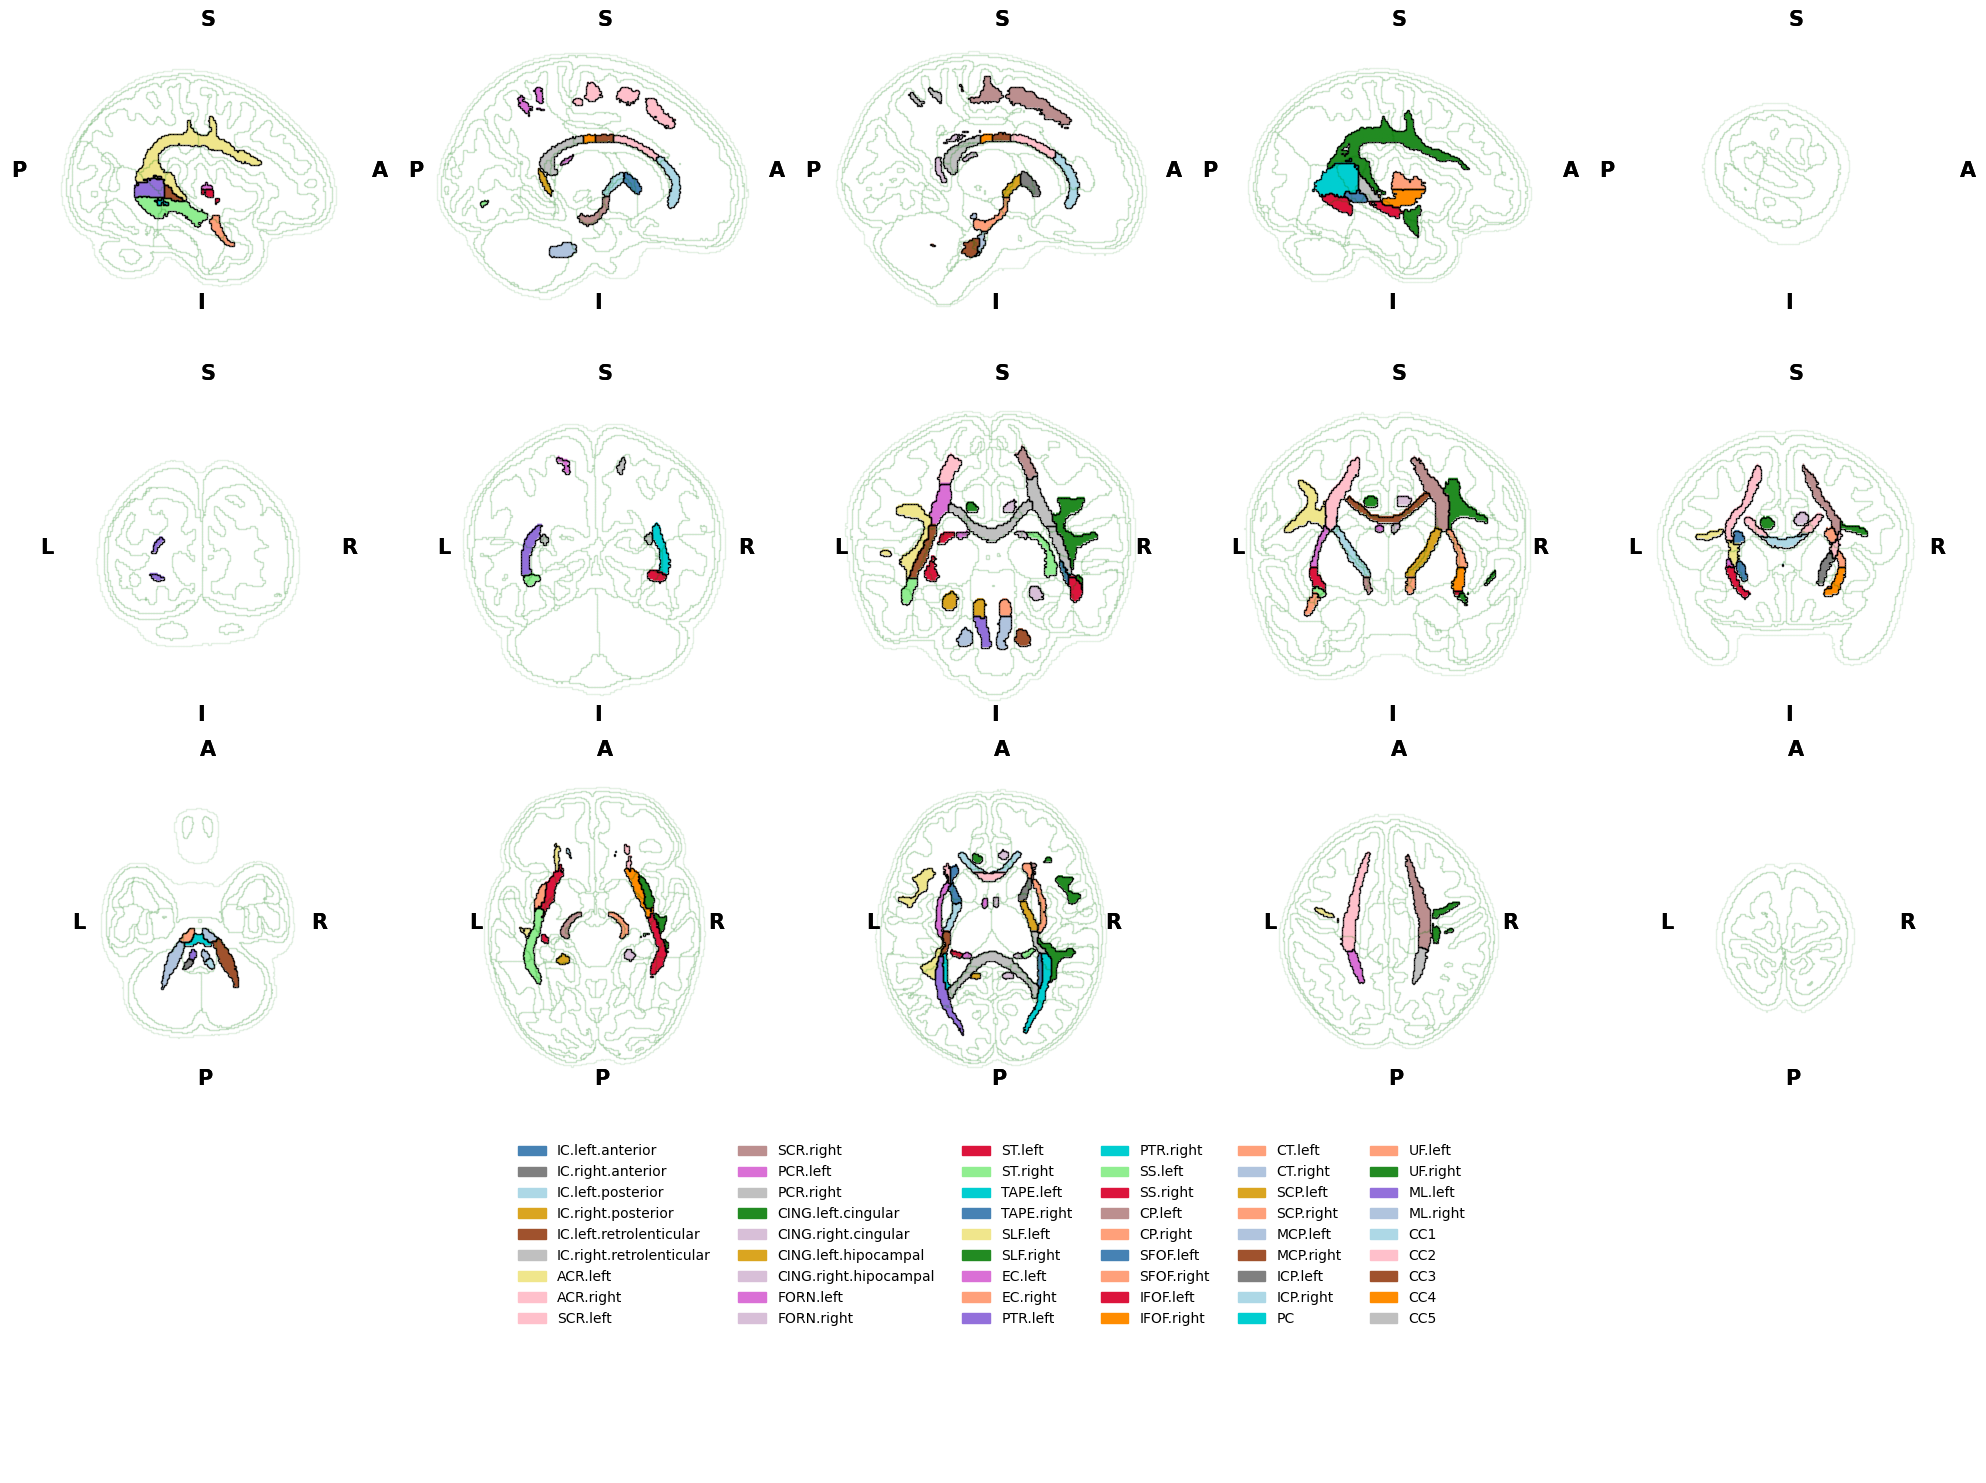

In [88]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4,5)
row1 = [fig.add_subplot(gs[0,i]) for i in range(5)]
row2 = [fig.add_subplot(gs[1,i]) for i in range(5)]
row3 = [fig.add_subplot(gs[2,i]) for i in range(5)]
row4 = fig.add_subplot(gs[3,:])
row4.set_axis_off()
tract_legend = {int(k.replace('wm_','')):v['abbr'] for k,v in data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation().items()}
# fig,axes = plt.subplots(1,3,figsize=(20,10))
atlas_slices = [int(i) for i in np.linspace(50,180,5)]
# atlas_slices = [int(i) for i in np.linspace(105,180,5)]
# fig,axes = plt.subplots(3,5,figsize=(20,15))
axes = np.array([row1,row2,row3])
# axes = axes.flatten()
for map_view,row in zip(['sagittal','coronal','axial'],range(axes.shape[0])):
    for atlas_slice,ax in zip(atlas_slices,axes[row,:]):
        _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
            map_view = [map_view],
            regions_to_hide=[i for i in range(88)],
            atlas_slice=atlas_slice,
            outline_alpha=0.1,
            outline_colour='green',
            axes=ax)

        _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
            map_view = [map_view],
            atlas_slice=atlas_slice,
            plot_values_threshold=0.95,
            cb_title='$1-p_{val}$',
            cb_orientation='horizontal',
            cmap='tab20',
            label_legend=tract_legend,
            outline_label_legends=False,
            label_legend_axis=row4,
            label_legend_loc='upper center',
            label_legend_bbox_to_anchor=None,
            axes=ax,fig=fig)
        
plt.tight_layout()
# fig.savefig('tract_plot.png',dpi=300)
# fig.savefig('tract_plot.pdf')


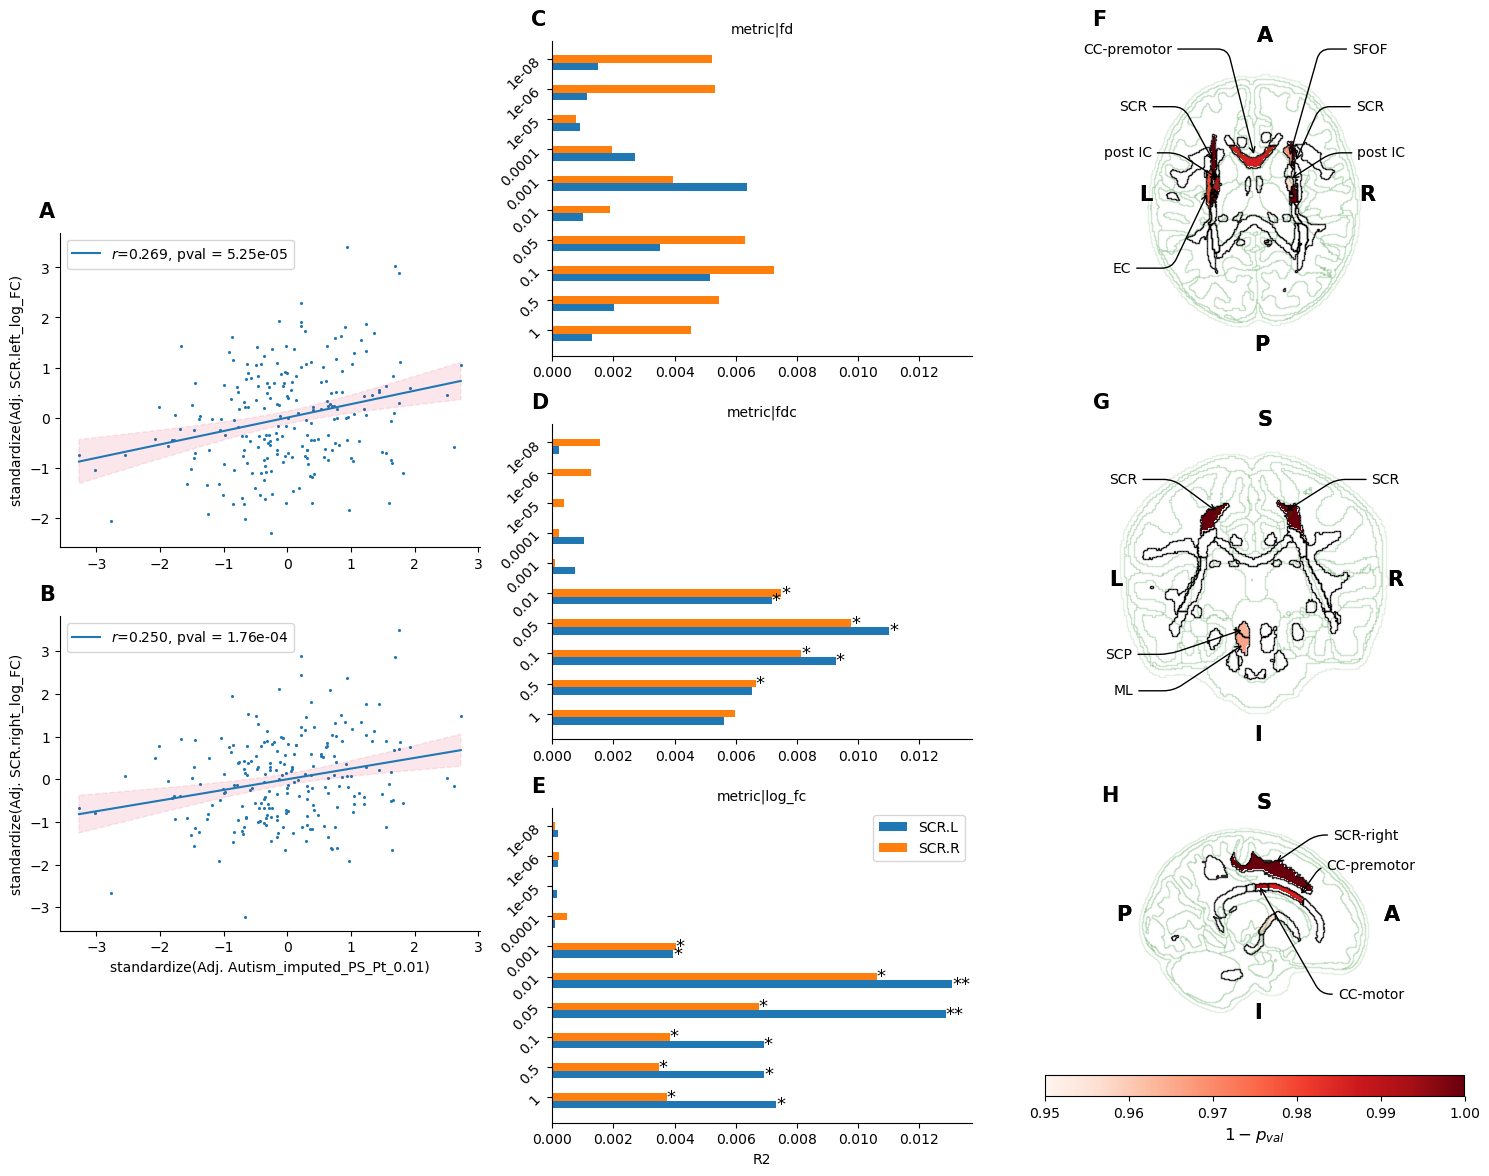

In [35]:
fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(12,3)
axes1 = fig.add_subplot(gs[2:6, 0])
axes2 = fig.add_subplot(gs[6:10, 0])
# axes3 = fig.add_subplot(gs[6:9, 0])
# axes4 = fig.add_subplot(gs[9:12, 0])

# axes1.get_shared_x_axes().join(axes1, axes2)


axes5 = fig.add_subplot(gs[0:4, 1])
axes6 = fig.add_subplot(gs[4:8, 1])
axes7 = fig.add_subplot(gs[8:12, 1])

for ax in [axes6,axes7]:
    ax.sharey(axes5)
    ax.sharex(axes5)


axes8 = fig.add_subplot(gs[0:4, 2])
axes9 = fig.add_subplot(gs[4:8, 2])
axes10 = fig.add_subplot(gs[8:12, 2])

for idx,(ax,connection,name) in enumerate(zip([axes1,axes2],['wm_102_log_fc','wm_103_log_fc'],
                             ['SCR.left','SCR.right'])):
    visualisation.SimplePlots.Scatter(y=connection,
                                      x='ASD_imputed_PRS_Pt_0.01',
                                      data=df,
                                      adjust_covar={'y':['sex','GA','PMA','TBV'],
                                                   'x':ancestry},ax=ax,fig=fig,legend_loc='upper left',
                                     ylabel=f'{name}_log_FC',
                                     xlabel='Autism_imputed_PS_Pt_0.01')
    if idx==0:
        ax.set_xlabel('')
sns.despine()

visualisation.SimplePlots.Bar(
    x='thresholds',
    y='R2',
    hue='tract',
    data=r_squared_df,
    separateby='type',
    annotate='significance',
    annotate_fontsize=13,
    order={'hue':['SCR.L','SCR.R'],'x':[i.split('_')[-1] for i in df.columns if 'ASD_imputed_PRS' in i][::-1]},
    figsize=(15,5),
    barwidth=0.5,
    ylabel_pos=(-.015,.6),
    ylabel='',
    plot_label='metric',
    xlabel='',
    fig=fig,ax=np.array([axes5,axes6,axes7]),orientation='horizontal',rotation_x=90,legend_loc='upper right')

axes7.set_xlabel('R2')

for idx,ax in enumerate([axes5,axes6,axes7]):
    ax.tick_params(axis='y',rotation=45)
    
atlas_slice=120
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=np.array([axes8,axes9,axes10]))
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=np.array([axes8,axes9,axes10]),fig=fig,colorbar=True,cb_vmin=0.95,cb_vmax=1)

############################################

axes8.annotate('CC-premotor',
            xy=(100, 100), xycoords='data',
            xytext=(-10, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=100,rad=10"),
            horizontalalignment='center')
axes8.annotate('SCR',
            xy=(65, 105), xycoords='data',
            xytext=(-5, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('SCR',
            xy=(135, 105), xycoords='data',
            xytext=(200, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('post IC',
            xy=(70, 120), xycoords='data',
            xytext=(-10, 100), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('post IC',
            xy=(130, 120), xycoords='data',
            xytext=(210, 100), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes8.annotate('EC',
            xy=(60, 130), xycoords='data',
            xytext=(-15, 200), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes8.annotate('SFOF',
            xy=(130, 101), xycoords='data',
            xytext=(200, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

################################################

axes9.annotate('SCR',
            xy=(75, 60), xycoords='data',
            xytext=(10, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('SCR',
            xy=(120, 60), xycoords='data',
            xytext=(190, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('ML',
            xy=(93, 150), xycoords='data',
            xytext=(10, 185), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('SCP',
            xy=(93, 140), xycoords='data',
            xytext=(7, 160), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('SCR-right',
            xy=(155, 54), xycoords='data',
            xytext=(245, 30), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('CC-premotor',
            xy=(180, 86), xycoords='data',
            xytext=(250, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('CC-motor',
            xy=(140, 75), xycoords='data',
            xytext=(250, 186), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')
################################################

for ax, number in zip([axes1,axes2,axes5,axes6,axes7],['A','B','C','D','E']):
    ax.text(-0.05, 1.1, number, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top')

axes8.text(-0.2,1.1,'F',transform=axes8.transAxes,fontsize=15,fontweight='bold',va='top')
axes9.text(-0.05,1.1,'G',transform=axes9.transAxes,fontsize=15,fontweight='bold',va='top')
axes10.text(-0.05,1.1,'H',transform=axes10.transAxes,fontsize=15,fontweight='bold',va='top')
# fig.text(0, 0.98, 'Correlation between ASD PRS Pt=0.001 \n and logFC of superior corona radiata')
plt.tight_layout()
fig.savefig('result_plot.png')
# fig.savefig('result_plot.pdf')

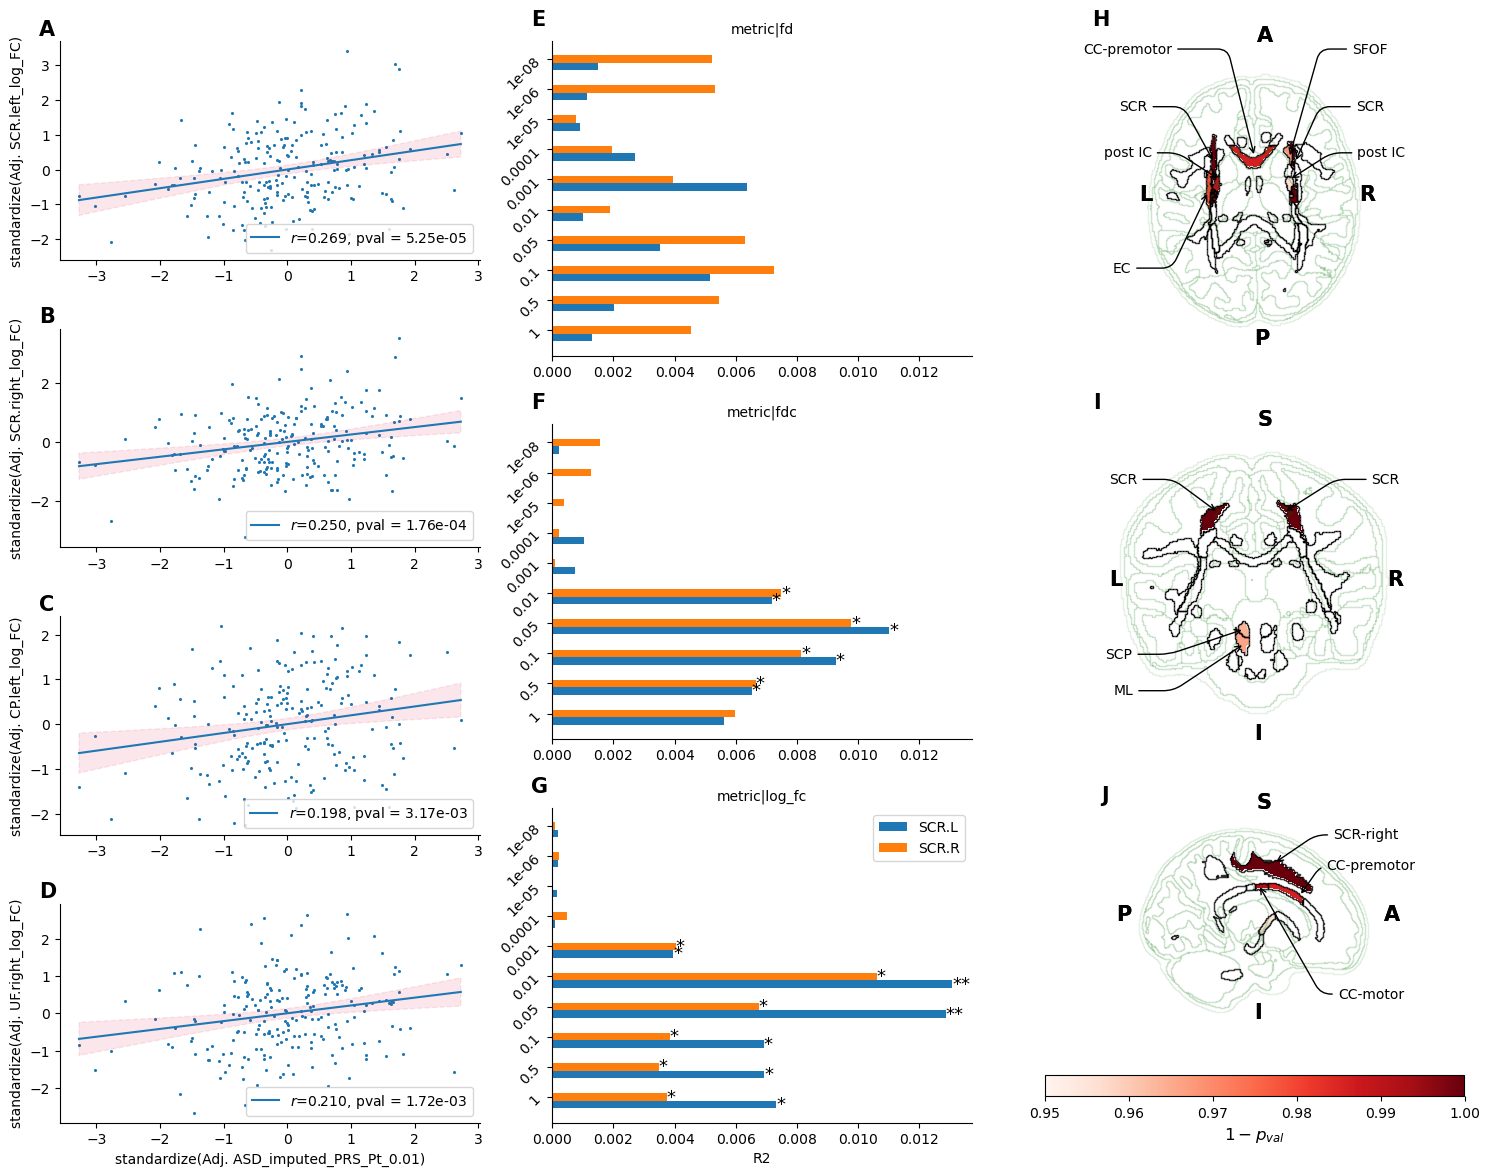

In [19]:
fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(12,3)
axes1 = fig.add_subplot(gs[0:3, 0])
axes2 = fig.add_subplot(gs[3:6, 0])
axes3 = fig.add_subplot(gs[6:9, 0])
axes4 = fig.add_subplot(gs[9:12, 0])

axes1.get_shared_x_axes().join(axes1, axes2, axes3, axes4)


axes5 = fig.add_subplot(gs[0:4, 1])
axes6 = fig.add_subplot(gs[4:8, 1])
axes7 = fig.add_subplot(gs[8:12, 1])

for ax in [axes6,axes7]:
    ax.sharey(axes5)
    ax.sharex(axes5)


axes8 = fig.add_subplot(gs[0:4, 2])
axes9 = fig.add_subplot(gs[4:8, 2])
axes10 = fig.add_subplot(gs[8:12, 2])

for idx,(ax,connection,name) in enumerate(zip([axes1,axes2,axes3,axes4],['wm_102_log_fc','wm_103_log_fc','wm_124_log_fc','wm_140_log_fc'],
                             ['SCR.left','SCR.right','CP.left','UF.right'])):
    visualisation.SimplePlots.Scatter(y=connection,
                                      x='ASD_imputed_PRS_Pt_0.01',
                                      data=df,
                                      adjust_covar={'y':['sex','GA','PMA','TBV'],
                                                   'x':ancestry},ax=ax,fig=fig,legend_loc='lower right',
                                     ylabel=f'{name}_log_FC')
    if idx<3:
        ax.set_xlabel('')
sns.despine()

visualisation.SimplePlots.Bar(
    x='thresholds',
    y='R2',
    hue='tract',
    data=r_squared_df,
    separateby='type',
    annotate='significance',
    annotate_fontsize=13,
    order={'hue':['SCR.L','SCR.R'],'x':[i.split('_')[-1] for i in df.columns if 'ASD_imputed_PRS' in i][::-1]},
    figsize=(15,5),
    barwidth=0.5,
    ylabel_pos=(-.015,.6),
    ylabel='',
    plot_label='metric',
    xlabel='',
    fig=fig,ax=np.array([axes5,axes6,axes7]),orientation='horizontal',rotation_x=90,legend_loc='upper right')

axes7.set_xlabel('R2')

for idx,ax in enumerate([axes5,axes6,axes7]):
    ax.tick_params(axis='y',rotation=45)
    
atlas_slice=120
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=np.array([axes8,axes9,axes10]))
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=np.array([axes8,axes9,axes10]),fig=fig,colorbar=True,cb_vmin=0.95,cb_vmax=1)

############################################

axes8.annotate('CC-premotor',
            xy=(100, 100), xycoords='data',
            xytext=(-10, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=100,rad=10"),
            horizontalalignment='center')
axes8.annotate('SCR',
            xy=(65, 105), xycoords='data',
            xytext=(-5, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('SCR',
            xy=(135, 105), xycoords='data',
            xytext=(200, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('post IC',
            xy=(70, 120), xycoords='data',
            xytext=(-10, 100), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('post IC',
            xy=(130, 120), xycoords='data',
            xytext=(210, 100), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes8.annotate('EC',
            xy=(60, 130), xycoords='data',
            xytext=(-15, 200), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes8.annotate('SFOF',
            xy=(130, 101), xycoords='data',
            xytext=(200, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

################################################

axes9.annotate('SCR',
            xy=(75, 60), xycoords='data',
            xytext=(10, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('SCR',
            xy=(120, 60), xycoords='data',
            xytext=(190, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('ML',
            xy=(93, 150), xycoords='data',
            xytext=(10, 185), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('SCP',
            xy=(93, 140), xycoords='data',
            xytext=(7, 160), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('SCR-right',
            xy=(155, 54), xycoords='data',
            xytext=(245, 30), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('CC-premotor',
            xy=(180, 86), xycoords='data',
            xytext=(250, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('CC-motor',
            xy=(140, 75), xycoords='data',
            xytext=(250, 186), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')
################################################

for ax, number in zip([axes1,axes2,axes3,axes4,axes5,axes6,axes7],['A','B','C','D','E','F','G']):
    ax.text(-0.05, 1.1, number, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top')

axes8.text(-0.2,1.1,'H',transform=axes8.transAxes,fontsize=15,fontweight='bold',va='top')
axes9.text(-0.05,1.1,'I',transform=axes9.transAxes,fontsize=15,fontweight='bold',va='top')
axes10.text(-0.05,1.1,'J',transform=axes10.transAxes,fontsize=15,fontweight='bold',va='top')

plt.tight_layout()
# fig.savefig('result_plot.png')
# fig.savefig('result_plot.pdf')

A-D Scatter plots of association between mean log FC of 4 tracts and ASD-PRS at Pt 0.01. E-G Bar plots of R-squared explained by PRS across different Pt. * p < 0.05 ** p < 7.7e-5 . H-J Visual representation of tracts with mean log FC associated with ASD-PRS at Pt 0.01. (CC- corpus callosum, SCR- superior corona radiata, SFOF – Superior fronto-occipital fasciculus, post IC – posterior internal capsule, EC – external capsule, ML – medial lemnicus, SCP – superior cerebral peduncle 

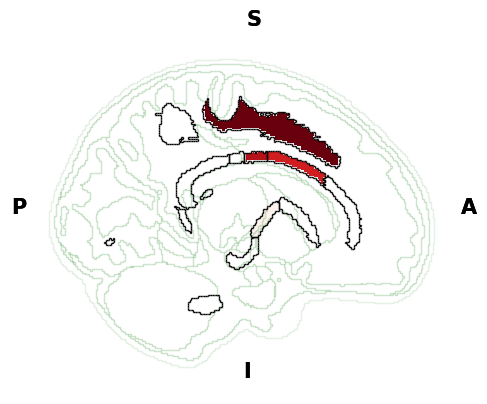

In [221]:
fig,ax = plt.subplots(1,1)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],map_view=['sagittal'],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=ax)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,map_view=['sagittal'],
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=ax,fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)

Text(250, 186, 'CC-motor')

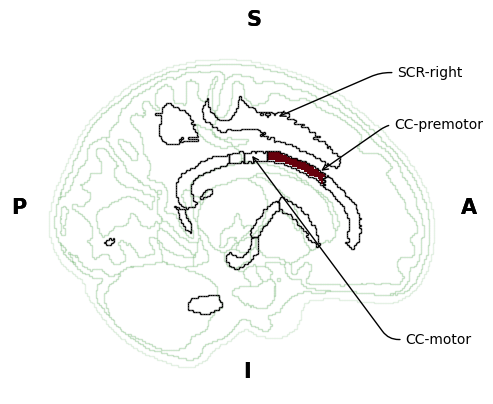

In [254]:
fig,ax = plt.subplots(1,1)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],map_view=['sagittal'],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=ax)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values={144:1},map_view=['sagittal'],
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=ax,fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)

ax.annotate('SCR-right',
            xy=(155, 54), xycoords='data',
            xytext=(245, 30), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

ax.annotate('CC-premotor',
            xy=(180, 86), xycoords='data',
            xytext=(250, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

ax.annotate('CC-motor',
            xy=(140, 75), xycoords='data',
            xytext=(250, 186), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

In [168]:
{data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[f'wm_{k}']['abbr']:(v,k) for k,v in to_plot_values.items() if v > 0.95}

{'IC.left.posterior': (0.9876013937804962, 96),
 'IC.right.posterior': (0.9508115508876271, 97),
 'SCR.left': (0.9999404380456216, 102),
 'SCR.right': (0.9997778608652838, 103),
 'EC.left': (0.9751382738771438, 118),
 'CP.left': (0.9970433645716436, 124),
 'SFOF.right': (0.9658738663626196, 127),
 'SCP.left': (0.9663995882986438, 132),
 'ICP.left': (0.9751326307360001, 136),
 'UF.right': (0.9961501946672568, 140),
 'ML.left': (0.9718495086821003, 141),
 'CC2': (0.9864608126201545, 144),
 'CC3': (0.9911114364322541, 145)}

In [103]:
data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()['wm_94']

{'name': 'anterior limb of internal capsule left',
 'side': 'left',
 'segment': 'anterior',
 'structure': 'internal capsule',
 'abbr': 'IC.left.anterior'}

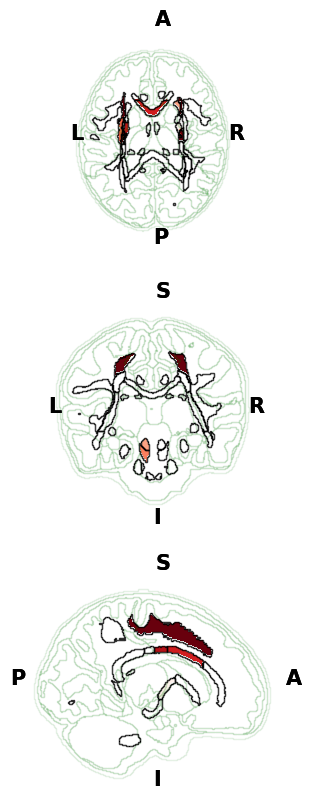

In [36]:
fig,axes=plt.subplots(3,1,figsize=(15,10))
axes = axes.flatten()
atlas_slice=120
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=axes[0:3])
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=axes[0:3],fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)


In [36]:
dHCP_outcomes = pd.read_csv(f'../../dataset/participant_outcome/DHCPNDH1-LeHaiOutcome_DATA_LABELS_2022-06-09_0947.csv')
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,6,11:13,13,16:19,21:24,34,56,77:92]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,13,18,23,83:90]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,83:90]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,21, 22, 23, 24, 25, 29, 30]].copy()
dHCP_outcomes_CBCL_Bayley['Assessment Age'] = dHCP_outcomes_CBCL_Bayley['Corrected Age - Months'] + dHCP_outcomes_CBCL_Bayley['Corrected Age - Days']/30
dHCP_outcomes_CBCL_Bayley.rename(columns={'IMD Score':'IMD'},inplace=True)
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes_CBCL_Bayley.dropna()
dHCP_total_QCHAT_SCORE = dHCP_outcomes.iloc[:,np.r_[0,72]]

In [37]:
GA = pd.read_table('../../dataset/participant_info/dHCP_release3_metadata.tsv').drop_duplicates(subset=['participant_id'])

In [38]:
euro_ancestry = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/ancestry_PCs/euro_batch2_genotyped_PCA_result.eigenvec',
                                                                              column_prefix='euro_Anc_')

In [39]:
df = dHCP_outcomes_CBCL_Bayley.merge(PRS_imputed_Grove,left_on='Participant ID',right_on='ID')
# df = df.merge(PRS_imputed_Grove,left_on='participant_id',right_on='ID').merge(dHCP_outcomes_CBCL_Bayley,left_on='ID',right_on='Participant ID')
df = df.merge(euro_ancestry,on='ID')
df = df.merge(GA, left_on = 'ID', right_on = 'participant_id')
Bayleys_metrics = [i for i in df.columns for n in ['Communication','Cognitive','Motor'] if n in i]

In [40]:
df = df[df['birth_age']>=37]

In [41]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df=df,
                                                                          thresholds=[i for i in df.columns if 'ASD_imputed' in i],
                                                                                 cat_independentVar_cols=["sex"],
                                    cont_independentVar_cols=['Assessment Age','IMD']+[f'euro_Anc_PC{i}' for i in range(1,4)],
                                                                         dependentVar_cols=Bayleys_metrics)

 ... (more hidden) ...


In [42]:
0.05/6/7

0.0011904761904761904

In [43]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('Assessment Age'))_coef,standardize(Q('Assessment Age'))_pval,standardize(IMD)_coef,standardize(IMD)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
26,Gross Motor Scaled Score,8.848366,5.563992e-128,0.718055,0.005806,0.016249,0.896184,-0.023363,0.851726,-0.163524,0.190701,0.064917,0.609884,-0.126000,0.319795,-0.448921,0.000568,ASD_imputed_PRS_Pt_0.0001
27,Sum Motor Scaled Scores,20.656594,6.888456e-167,0.452064,0.265387,0.038531,0.843737,-0.088133,0.653344,-0.290578,0.138721,-0.111402,0.576984,-0.151225,0.446646,-0.703853,0.000576,ASD_imputed_PRS_Pt_0.0001
21,Cognitive Scaled Score,10.848254,1.689508e-150,-0.497722,0.048314,-0.249801,0.039922,-0.072932,0.548479,0.074056,0.541559,-0.279137,0.024719,0.055279,0.653165,-0.327139,0.009393,ASD_imputed_PRS_Pt_0.0001
20,Sum Motor Scaled Scores,20.723415,1.334810e-166,0.318957,0.432314,0.053924,0.784996,-0.033486,0.865889,-0.295953,0.135968,-0.227365,0.259022,-0.123102,0.539472,-0.515156,0.010989,ASD_imputed_PRS_Pt_1e-05
23,Expressive Communication Scaled Score,9.859711,3.765678e-121,-0.672544,0.030479,0.177797,0.233907,-0.280469,0.061931,0.151057,0.312515,-0.162212,0.287529,0.335797,0.027465,-0.386179,0.012772,ASD_imputed_PRS_Pt_0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Cognitive Scaled Score,10.924903,3.517730e-151,-0.650407,0.009158,-0.245311,0.047863,-0.056748,0.644924,0.076136,0.539724,-0.317281,0.013414,0.074854,0.548515,0.008754,0.945080,ASD_imputed_PRS_Pt_0.5
49,Cognitive Scaled Score,10.924310,3.746484e-151,-0.649225,0.009314,-0.244014,0.048075,-0.056362,0.647038,0.074067,0.551147,-0.314288,0.013519,0.074113,0.552092,-0.006576,0.958241,ASD_imputed_PRS_Pt_0.1
35,Cognitive Scaled Score,10.924133,4.616860e-151,-0.648873,0.009476,-0.243999,0.048145,-0.056668,0.645383,0.074263,0.548745,-0.314688,0.012672,0.074443,0.550081,-0.006310,0.959584,ASD_imputed_PRS_Pt_0.01
30,Expressive Communication Scaled Score,9.949481,1.119743e-121,-0.851367,0.006040,0.184193,0.223420,-0.260971,0.085875,0.151950,0.317372,-0.204737,0.185476,0.358306,0.020058,-0.002637,0.986300,ASD_imputed_PRS_Pt_0.001


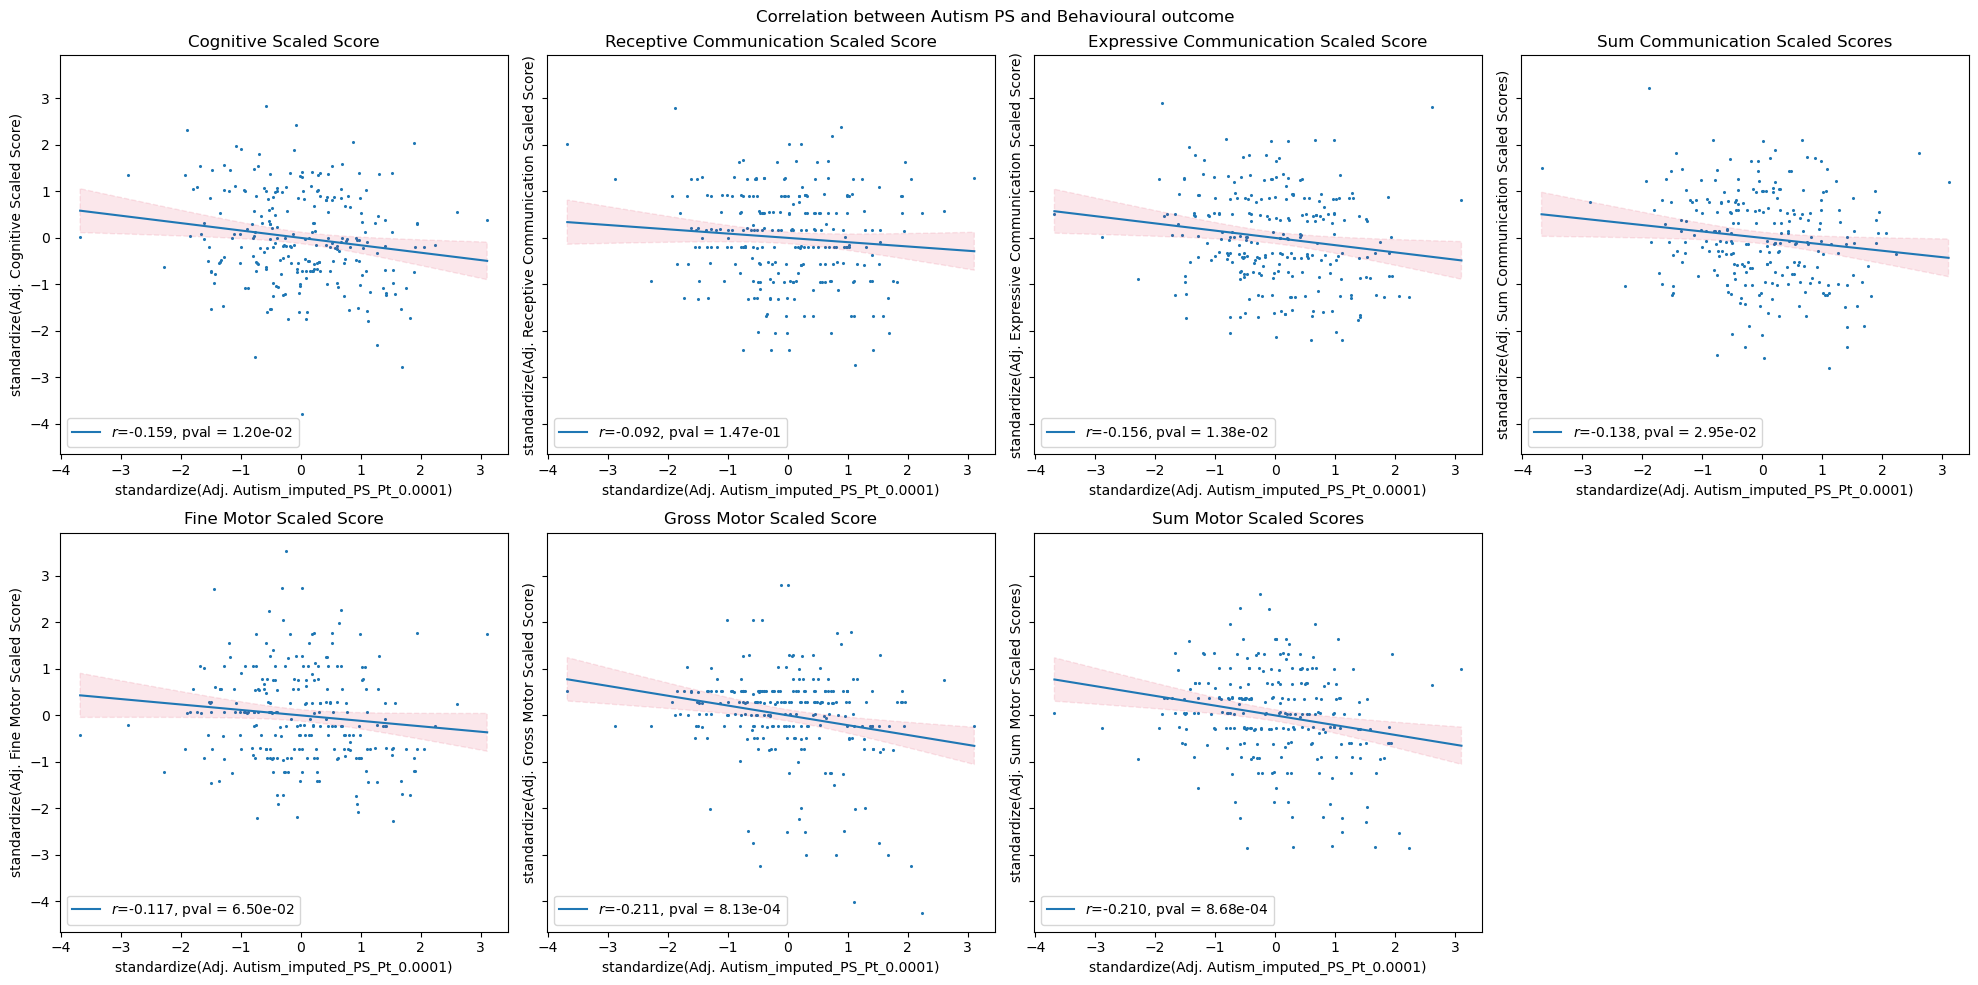

In [47]:
connections = Bayleys_metrics
fig,axes=plt.subplots(2,4,sharey=True,figsize=(20,10))
axes=axes.flatten()
for idx,(connection,ax) in enumerate(zip(connections,axes)):
    visualisation.SimplePlots.Scatter(
        y=connection,
        x='ASD_imputed_PRS_Pt_0.0001',
        adjust_covar={'y':['IMD','Assessment Age','sex'],'x':ancestry},
        data=df,
        # ylabel='tract mean FD',
        ax=ax,
        title=connection,
        legend_loc='lower left',
        xlabel='Autism_imputed_PS_Pt_0.0001'
    )
    # if idx>0:
    #     ax.set_ylabel('')
fig.suptitle('Correlation between Autism PS and Behavioural outcome')
plt.tight_layout()
fig.delaxes(axes[-1])
# fig.savefig('../../dataset/preprocessed_dataset/fba/asd/output_plot/mean_FDC_supplementary.png')
# fig.savefig('../../dataset/preprocessed_dataset/fba/asd/output_plot/mean_FD_supplementary.png')
fig.savefig('../../dataset/preprocessed_dataset/fba/asd/output_plot/cbcl_supplementary.png')

In [101]:
from collections import namedtuple

In [125]:
Dimensions = namedtuple("Dimensions", "columns rows")

def compute_product(matrixA, matrixB):
    matrixA_dim = Dimensions(len(matrixA[0]), len(matrixA))
    matrixB_dim = Dimensions(len(matrixB[0]), len(matrixB))
    product = []
    for col in range(matrixA_dim.rows):
        product.append([0 for row in range(matrixB_dim.columns)])
    for i in range(matrixA_dim.columns):
        for j in range(matrixB_dim.rows):
            product[i][j] += matrixA[i][j] * matrixB[j][j]
    return product

In [123]:
def test(matrixA,matrixB):
    return np.dot(np.array(matrixA),np.array(matrixB))

In [130]:
x = test(matrixA,matrixB)

In [134]:
[i for i in x[0]]

[208, 79, 160]

In [135]:
arr = np.array([
    [1.2, -0.3, 1.3],
    [1.2, 2., 0.3]
]).astype(np.float64)

In [172]:
test=pd.DataFrame([[1,np.nan,1],[2,2,np.nan]])

In [181]:
means = test.fillna(0).mean(axis=0)

In [182]:
means

0    1.5
1    2.0
2    1.5
dtype: float64

In [185]:
np.zeros((3,5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [176]:
test[1].fillna(means[1],inplace=True)

In [188]:
test1 = np.zeros((2,3))

In [192]:
test1[:,0] = test[[1]].values.reshape(-1)

In [197]:
test1[:,1]=[3,2]

In [198]:
test1

array([[2., 3., 0.],
       [2., 2., 0.]])

In [203]:
test.quantile(1,axis=1)

0    2.0
1    2.0
Name: 1.0, dtype: float64

In [193]:
test1

array([[2., 0., 0.],
       [2., 0., 0.]])

In [187]:
test[[1]].values

array([[2.],
       [2.]])

In [179]:
for col in test.columns:
    test[col].fillna(means[1],inplace=True)

In [180]:
test

,0,1,2
0,1,2.0,1.0
1,2,2.0,2.0


In [138]:
means = np.mean(arr,axis=1)
stds = np.std(arr,axis=1)

In [155]:
(arr - means.reshape(-1,1))/stds.reshape(-1,1)

array([[ 0.63768253, -1.41201131,  0.77432878],
       [ 0.04800154,  1.2000384 , -1.24803994]])

In [127]:
compute_product(matrixA,matrixB)

IndexError: list index out of range

In [104]:
matrixA = [[11,  3, 10, 3], [20, 1, 0, 1]]
matrixB = [[12,  1, 10], [7, 4, 0], [4, 5, 2], [5, 2, 10]]

In [110]:
matrixA_dim = Dimensions(len(matrixA[0]), len(matrixA))
matrixB_dim = Dimensions(len(matrixB[0]), len(matrixB))

In [109]:
matrixA_dim

Dimensions(columns=4, rows=2)

In [111]:
matrixB_dim

Dimensions(columns=3, rows=4)

In [112]:
product = []
for col in range(matrixA_dim.columns):
    product.append([0 for row in range(matrixB_dim.rows)])

In [113]:
product

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [78]:
df.shape

(249, 110)

In [80]:
Bayleys_metrics

['Cognitive Scaled Score',
 'Receptive Communication Scaled Score',
 'Expressive Communication Scaled Score',
 'Sum Communication Scaled Scores',
 'Fine Motor Scaled Score',
 'Gross Motor Scaled Score',
 'Sum Motor Scaled Scores']

In [82]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(df[[i for i in df.columns if 'ASD_imputed_PRS' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 8.074362349201188
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 6.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.00833333333333333


6.000000000000003

<AxesSubplot:xlabel='standardize(Adj. ASD_PRS_Pt_0.01)', ylabel='standardize(Adj. log_FC_mean_significant_fixels)'>

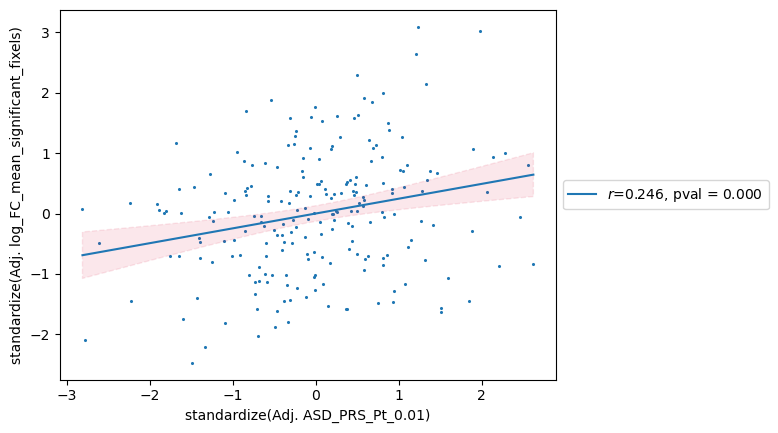

In [67]:
visualisation.SimplePlots.Scatter(y='log_FC_mean_significant_fixels',x='ASD_PRS_Pt_0.01',data=df,
                                 adjust_covar={'y':['TBV','GA','PMA','sex'],'x':ancestry})

In [61]:
df = pd.concat([df,log_fc_mean_L_R],axis=1)

In [58]:
log_fc_mean_L_R.columns = ['log_FC_mean_significant_fixels']

In [55]:
log_fc_mean_L_R = pd.read_csv('../../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-log_fc-cst_L_R-significant.txt',header=None)

In [ ]:
visualisation.SimplePlots.Scatter(y='mean_',x='ASD_PRS_Pt_0.01',data=df,
                                 adjust_covar={'y':['TBV','GA','PMA','sex'],'x':ancestry})

In [51]:
0.05/6

0.008333333333333333

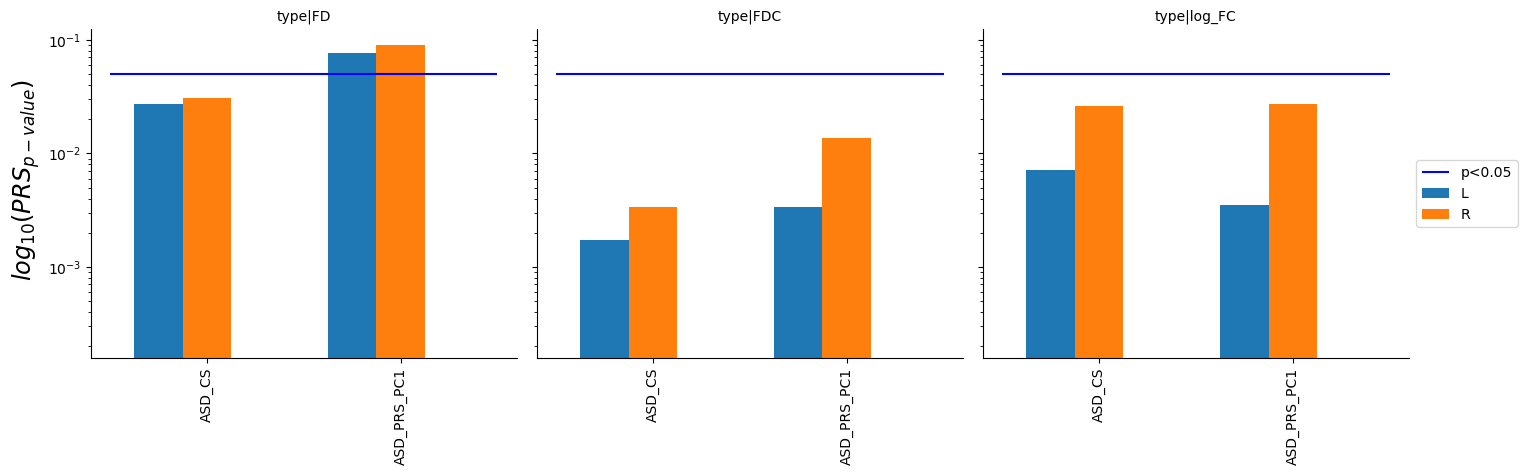

In [17]:
visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Tract',data=to_plot,
                          separateby='type',
                         order={
                               'hue':['L','R']},yscalelog=True,
                         ylabel='$log_{10}(PRS_{p-value})$',rotation_x=90,
                              hline=[0.05],hline_label=['p<0.05'],
                         figsize=(15,5),barwidth=0.5,xlabel=None,ylabel_pos=(-.015,.6))
plt.tight_layout()
sns.despine()

In [15]:
to_plot = pd.concat([test[['Connection','PRS_pval','threshold']],
          test2[['Connection','PRS_pval','threshold']]]).copy()

to_plot = to_plot[to_plot['threshold'].isin([i for i in df.columns if 'ASD_CS' in i or 'ASD_PRS_PC1' in i])].copy()

# to_plot = pd.concat([test[['Connection','PRS_pval','threshold']],
#           test2[['Connection','PRS_pval','threshold']]]).copy()
# to_plot = test[['Connection','PRS_pval','threshold']].copy()
to_plot['type'] = to_plot['Connection'].apply(lambda x: x.split('_mean')[0])

to_plot['Tract'] = to_plot['Connection'].apply(lambda x: '+'.join(x.split('_mean')[1].split('_')[1:]))

# visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Connection',data=to_plot[to_plot['type']=='log_FC'],
#                               order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]},
#                               yscalelog=True,hline=0.05,rotation_x=90)

In [50]:
visualisation.SimplePlots.Groupby.groupby(separateby,x,hue,y=y,colorby=colorby,y2=y2)

TypeError: unhashable type: 'numpy.ndarray'

In [59]:
args = groupby(separateby,x,hue,y=y)

In [58]:
def groupby(*args,**kwargs):
    args = [list(chain.from_iterable(i)) for i in args if i is not None]
    kwargs = {k:v for k,v in kwargs.items() if v is not None}
    all_unique_keys = [tuple(set(i)) for i in args]
    all_possible_keys = product(*all_unique_keys)
    all_values = list(kwargs.keys())

    return all_possible_keys

In [13]:
def dictionary_merge(dict1,dict2):
#convenience function to merge nested dictionary together
    for key in dict2:
        if key in dict1:
            if isinstance(dict1[key],dict) and isinstance(dict2[key],dict):
                dictionary_merge(dict1[key],dict2[key])
        else:
            dict1[key]=dict2[key]
    return dict1

In [54]:
from itertools import chain,product

In [11]:
y2=[0 for i in range(len(x))]

In [9]:
x,y,colorby,separateby,hue = visualisation.SimplePlots.Bar(x='thresholds',y='R2',hue='tract',data=r_squared_df,separateby='type')

In [116]:
{k:v for k,v in to_plot_values.items() if v > 0.95}

{96: 0.9876013937804962,
 97: 0.9508115508876271,
 102: 0.9999404380456216,
 103: 0.9997778608652838,
 118: 0.9751382738771438,
 124: 0.9970433645716436,
 127: 0.9658738663626196,
 132: 0.9663995882986438,
 136: 0.9751326307360001,
 140: 0.9961501946672568,
 141: 0.9718495086821003,
 144: 0.9864608126201545,
 145: 0.9911114364322541}

In [25]:
log_fc_res_best

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,...,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold,tract
0,wm_102_log_fc,0.055408,0.201444,-0.110316,0.091429,0.085344,0.026468,0.027783,0.625102,0.864737,...,0.010341,0.723728,-0.019254,0.508398,0.003394,0.907277,0.118679,0.000060,ASD_imputed_PRS_Pt_0.01,SCR.left
2,wm_103_log_fc,0.023166,0.582205,-0.046124,0.466739,0.076855,0.039679,0.078142,0.158392,0.830371,...,-0.003253,0.908947,-0.009597,0.734501,-0.002124,0.940255,0.105821,0.000222,ASD_imputed_PRS_Pt_0.01,SCR.right
5,wm_124_log_fc,0.070584,0.155942,-0.140531,0.060914,0.129679,0.003403,0.161081,0.014116,0.704243,...,0.018247,0.586467,-0.009139,0.784134,-0.020906,0.531659,0.099859,0.002957,ASD_imputed_PRS_Pt_0.01,CP.left
9,wm_140_log_fc,-0.039773,0.486419,0.079187,0.357268,-0.070269,0.164531,-0.080373,0.284468,0.891999,...,-0.015186,0.693968,-0.019638,0.609065,-0.041692,0.278832,0.111679,0.003850,ASD_imputed_PRS_Pt_0.01,UF.right


In [22]:
log_fc_res[log_fc_res['threshold']=='ASD_imputed_PRS_Pt_0.01']

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
0,wm_102_log_fc,0.055408,0.201444,-0.110316,0.091429,0.085344,0.026468,0.027783,6.251016e-01,0.864737,3.572124e-43,0.010341,0.723728,-0.019254,0.508398,0.003394,0.907277,0.118679,0.000060,ASD_imputed_PRS_Pt_0.01
2,wm_103_log_fc,0.023166,0.582205,-0.046124,0.466739,0.076855,0.039679,0.078142,1.583919e-01,0.830371,1.709630e-42,-0.003253,0.908947,-0.009597,0.734501,-0.002124,0.940255,0.105821,0.000222,ASD_imputed_PRS_Pt_0.01
5,wm_124_log_fc,0.070584,0.155942,-0.140531,0.060914,0.129679,0.003403,0.161081,1.411629e-02,0.704243,4.076419e-27,0.018247,0.586467,-0.009139,0.784134,-0.020906,0.531659,0.099859,0.002957,ASD_imputed_PRS_Pt_0.01
9,wm_140_log_fc,-0.039773,0.486419,0.079187,0.357268,-0.070269,0.164531,-0.080373,2.844681e-01,0.891999,4.402888e-31,-0.015186,0.693968,-0.019638,0.609065,-0.041692,0.278832,0.111679,0.003850,ASD_imputed_PRS_Pt_0.01
12,wm_145_log_fc,-0.006132,0.915913,0.012209,0.888891,-0.005217,0.918987,-0.019058,8.026749e-01,0.838529,8.430270e-28,0.027746,0.479802,0.017026,0.662819,-0.043707,0.264306,0.102625,0.008889,ASD_imputed_PRS_Pt_0.01
14,wm_96_log_fc,0.053970,0.315353,-0.107453,0.184378,0.044165,0.352108,0.425191,6.877725e-09,0.473234,3.926244e-13,0.012813,0.723977,-0.012150,0.736385,-0.021121,0.559105,0.090606,0.012399,ASD_imputed_PRS_Pt_0.01
16,wm_144_log_fc,0.000572,0.993117,-0.001138,0.990892,-0.076058,0.194546,-0.280323,1.453952e-03,0.958408,7.062354e-28,0.003038,0.945899,0.026205,0.556404,-0.023456,0.599067,0.110394,0.013539,ASD_imputed_PRS_Pt_0.01
21,wm_118_log_fc,-0.014320,0.781354,0.028511,0.713440,0.045690,0.316516,0.083949,2.160671e-01,0.785104,5.738290e-30,0.004570,0.895687,-0.007270,0.833938,0.019767,0.569381,0.078002,0.024862,ASD_imputed_PRS_Pt_0.01
22,wm_136_log_fc,0.054887,0.291229,-0.109280,0.162960,0.138164,0.002876,0.195116,4.596692e-03,0.665432,2.409898e-23,-0.038859,0.268838,0.022479,0.519824,-0.023117,0.508695,0.078524,0.024867,ASD_imputed_PRS_Pt_0.01
27,wm_141_log_fc,0.093952,0.060382,-0.187058,0.013238,0.134125,0.002564,0.185393,4.989790e-03,0.689695,3.673539e-26,-0.011052,0.742700,0.008148,0.807762,0.009450,0.778140,0.073684,0.028150,ASD_imputed_PRS_Pt_0.01


In [32]:
!xdg-open test.png

In [16]:
set(product(separateby,x))

TypeError: unhashable type: 'numpy.ndarray'

In [18]:
list(chain.from_iterable(separateby))

['fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc']